In [1]:
import torch
import torchvision
import numpy as np
import wandb
from copy import copy

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from models.mnist.mnist_net import MnistNet
from models.mnist.gating_network import FMGate, MnistNetGate
from models.mnist.generic_gating_network import GenericFMGate, GenericMnistNetGet
from datasets.mnist_dataset import MNISTDataset
from utils.dataset_utils import train_test_split, build_subset, get_transformation

from itertools import combinations 

In [229]:
# Set seeds
torch.manual_seed(42)
np.random.seed(42)

# Define transformations
transformations_mnist_default = get_transformation('mnist')

# Load test sets
mnist_default_test_full = MNISTDataset('../../../data/default_mnist/testing', transform=transformations_mnist_default)
test_sets = []
comb = combinations([i for i in range(10)], 2)
for i, labels in enumerate(comb):
    mnist_test_sub = MNISTDataset('../../../data/default_mnist/training', transform=transformations_mnist_default, labels=labels)
    test_sets.append(mnist_test_sub)

# Load label-wise test sets
test_sets_label_wise = []
for i in range(10):
    dataset = MNISTDataset('../../../data/default_mnist/testing', transform=transformations_mnist_default, labels=[str(i)])
    test_sets_label_wise.append(dataset) 

In [3]:
# Define experts
def build_experts():
    experts = []
    for j, classes in enumerate(combinations([i for i in range(10)], 2)):
        expert = MnistNet(classes=classes, name='Label_expert_' + str(classes))
        experts.append(expert)
    experts = torch.nn.ModuleList(experts)
    return experts 

In [137]:
def gini(arr):
    ## first sort
    sorted_arr = arr.copy()
    sorted_arr.sort()
    n = arr.size
    coef_ = 2. / n
    const_ = (n + 1.) / n
    weighted_sum = sum([(i+1)*yi for i, yi in enumerate(sorted_arr)])
    gini = coef_*weighted_sum/(sorted_arr.sum()) - const_
    normalized_gini = gini * (n / (n-1))
    return np.round(normalized_gini, 4)

def lorenz_curve(X):
    X_lorenz = X.cumsum() / X.sum()
    X_lorenz = np.insert(X_lorenz, 0, 0) 
    X_lorenz[0], X_lorenz[-1]
    fig, ax = plt.subplots(figsize=[6,6])
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    ## scatter plot of Lorenz curve
    ax.scatter(np.arange(X_lorenz.size)/(X_lorenz.size-1), X_lorenz, color='blue', s=50)

    ## line plot of equality
    ax.plot([0,1], [0,1], color='orange', linewidth=5) 
    plt.text(0.05, 0.9, '$Gini=$' + str(gini(X)), fontsize=25, bbox=dict(fill=False, alpha=0.0))
    plt.xlabel("Share of experts $u_j$", fontsize=20)
    plt.ylabel("Share of weights $v_j$", fontsize=20)


In [241]:
def correct_assignments(model):
    result = []
    for test in test_sets_label_wise:
        weights = torch.zeros(45, requires_grad=False).to('cuda:0')
        loader = torch.utils.data.DataLoader(test, batch_size=128)
        for (image, label) in loader:
            image = image.to('cuda:0')
            weights += model.forward(image, output_only=False)['weights'].sum(dim=0).detach() 
        comb = combinations([i for i in range(10)], 2)
        weights_dict = {c: weights[i] for i, c in enumerate(comb)}
        sum_weights = 0.0
        for key, value in weights_dict.items():
            if str(test.labels[0]) in str(key):
                sum_weights += value.item()
        result.append(sum_weights)
    return result

## Analyze FM Gates

In [17]:
runpaths_fmgates = ['lukas-struppek/final_mnist_tests/223teliz', 'lukas-struppek/final_mnist_tests/1yccg51d', 'lukas-struppek/final_mnist_tests/3ldc3blh']
files_fmgates = ['BinSplit_FMGate_' + str(i) + '_final.tar' for i in range(3)]
fmgates = []

for i in range(3):
    model = FMGate(classes=[i for i in range(10)], experts=build_experts(), name='CombinationSplit_FMGate_' + str(i))
    file = wandb.restore(files_fmgates[i], run_path=runpaths_fmgates[i])
    model.load_state_dict(torch.load(file.name)['model_state_dict'])
    #model.evaluate(mnist_default_test_full, batch_size=128)
    fmgates.append(model) 

In [174]:
weights_fm_gate = torch.zeros(45, requires_grad=False).to('cuda:0')
model = fmgates[1]
model.to('cuda:0')
loader = torch.utils.data.DataLoader(mnist_default_test_full, batch_size=128)
for (image, label) in loader:
    weights_fm_gate += model.forward(image, output_only=False)['weights'].sum(dim=0).detach() 

In [237]:
weight_assignments_fm_gate = correct_assignments(fmgates[1])
np.sum(weight_assignments_fm_gate)/10000

0.9792638397398307

In [177]:
comb = combinations([i for i in range(10)], 2)
weights_fm_gate_dict = {c: weights_fm_gate[i] for i, c in enumerate(comb)}

In [201]:
sum = 0.0
for key, value in sorted(weights_fm_gate_dict.items(), key=lambda item: item[1], reverse=True)[:10]:
    print("%s: %s" % (key, np.round(value.item(), 2)))
    sum += np.round(value.item(), 2)
print(sum)

(4, 9): 1908.38
(1, 7): 1103.9
(7, 8): 1085.75
(0, 3): 1016.4
(5, 9): 943.48
(0, 4): 936.78
(6, 9): 922.26
(0, 2): 806.27
(1, 8): 780.32
(5, 8): 195.3
9698.839999999998


In [ ]:
weights_fm_gate = torch.zeros(45, requires_grad=False).to('cuda:0')
model = fmgates[1]
model.to('cuda:0')
loader = torch.utils.data.DataLoader(mnist_default_test_full, batch_size=128)
for (image, label) in loader:
    weights_fm_gate += model.forward(image, output_only=False)['weights'].sum(dim=0).detach() 

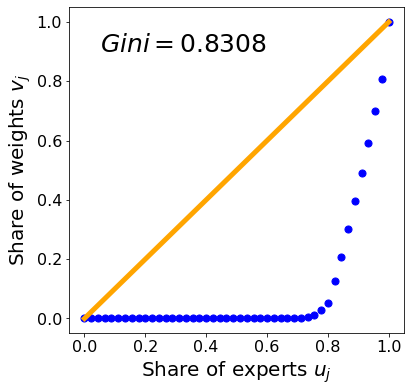

In [147]:
lorenz_curve(np.sort(weights_fm_gate.cpu().numpy())) 

In [242]:
weight_assignments_fm_gate = correct_assignments(fmgates[1])
np.sum(weight_assignments_fm_gate)/10000

0.9771683657748452

## Analyze MnistNetGates


In [66]:
runpaths_mnistnetgates = ['lukas-struppek/final_mnist_tests/1dey6h76', 'lukas-struppek/final_mnist_tests/12kgpny4', 'lukas-struppek/final_mnist_tests/3m51mfik']
files_mnistnetgates = ['BinSplit_MnistNetGate_' + str(i) + '_final.tar' for i in range(3)]
mnistnetgates = []

for i in range(3):
    model = MnistNetGate(classes=[i for i in range(10)], experts=build_experts(), name='CombinationSplit_MnistNetGate_' + str(i))
    file = wandb.restore(files_mnistnetgates[i], run_path=runpaths_mnistnetgates[i])
    model.load_state_dict(torch.load(file.name)['model_state_dict'])
    #model.evaluate(mnist_default_test_full, batch_size=128)
    mnistnetgates.append(model) 

In [67]:
weights_mnistnet_gate = torch.zeros(45, requires_grad=False).to('cuda:0')
model = mnistnetgates[2]
model.to('cuda:0')
loader = torch.utils.data.DataLoader(mnist_default_test_full, batch_size=128)
for (image, label) in loader:
    weights_mnistnet_gate += model.forward(image, output_only=False)['weights'].sum(dim=0).detach() 

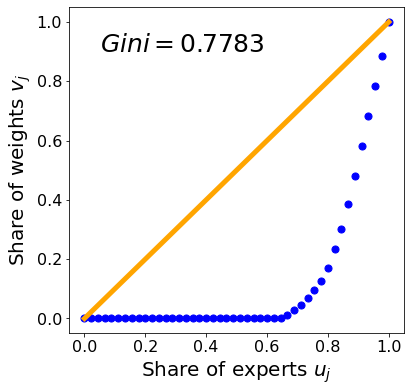

In [142]:
lorenz_curve(np.sort(weights_mnistnet_gate.cpu().numpy())) 

In [189]:
comb = combinations([i for i in range(10)], 2)
weights_mnistnet_gate_dict = {c: weights_mnistnet_gate[i] for i, c in enumerate(comb)}

In [199]:
sum = 0.0
for key, value in sorted(weights_mnistnet_gate_dict.items(), key=lambda item: item[1], reverse=True)[:10]:
    print("%s: %s" % (key, np.round(value.item(), 2)))
    sum += np.round(value.item(), 2)
print(sum)


(1, 8): 1159.25
(6, 7): 1013.96
(0, 3): 1013.23
(2, 5): 1012.26
(0, 1): 988.55
(2, 6): 957.75
(5, 9): 832.41
(0, 8): 691.62
(5, 6): 617.79
(4, 6): 461.32
8748.14


In [243]:
weight_assignments_mnistnet = correct_assignments(mnistnetgates[2])
np.sum(weight_assignments_mnistnet)/10000

0.979353300600817

## Analyze Generic FM Gates

In [69]:
runpaths_gen_fmgates = ['lukas-struppek/final_mnist_tests/3epqqlfl', 'lukas-struppek/final_mnist_tests/2d84msmw', 'lukas-struppek/final_mnist_tests/2vz3p84z']
files_gen_fmgates = ['BinSplit_GenericFMGate_' + str(i) + '_final.tar' for i in range(3)]
gen_fmgates = []

for i in range(3):
    model = GenericFMGate(classes=[i for i in range(10)], experts=build_experts(), name='CombinationSplit_GenericFMGate_' + str(i))
    file = wandb.restore(files_gen_fmgates[i], run_path=runpaths_gen_fmgates[i])
    model.load_state_dict(torch.load(file.name)['model_state_dict'])
    #model.evaluate(mnist_default_test_full, batch_size=128)
    gen_fmgates.append(model) 

In [70]:
weights_gen_fmgate = torch.zeros(45, requires_grad=False).to('cuda:0')
model = gen_fmgates[0]
model.to('cuda:0')
loader = torch.utils.data.DataLoader(mnist_default_test_full, batch_size=128)
for (image, label) in loader:
    image = image.to('cuda:0')
    weights_gen_fmgate += model.forward(image, output_only=False)['weights'].sum(dim=0).detach() 

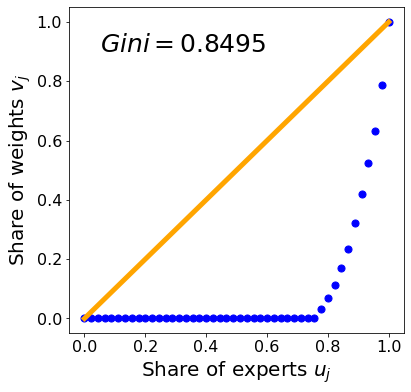

In [143]:
lorenz_curve(np.sort(weights_gen_fmgate.cpu().numpy())) 

In [187]:
comb = combinations([i for i in range(10)], 2)
weights_fm_gen_gate_dict = {c: weights_gen_fmgate[i] for i, c in enumerate(comb)}

In [200]:
sum = 0.0
for key, value in sorted(weights_fm_gen_gate_dict.items(), key=lambda item: item[1], reverse=True)[:10]:
    print("%s: %s" % (key, np.round(value.item(), 2)))
    sum += np.round(value.item(), 2)
print(sum)


(0, 1): 2119.43
(3, 9): 1547.18
(1, 7): 1088.54
(2, 6): 1049.5
(0, 4): 959.02
(1, 5): 901.11
(4, 7): 630.85
(0, 5): 572.42
(0, 7): 434.77
(2, 4): 377.18
9680.0


In [244]:
weight_assignments_fm_gate_gen = correct_assignments(gen_fmgates[0])
np.sum(weight_assignments_fm_gate_gen)/10000

0.747731029933691

## Analyze Generic MnistNet Gates


In [72]:
runpaths_gen_mnistnetgates = ['lukas-struppek/final_mnist_tests/x2k9zwac', 'lukas-struppek/final_mnist_tests/2qvrl30p', 'lukas-struppek/final_mnist_tests/38642wnh']
files_gen_mnistnetgates = ['BinSplit_GenericMnistGate_' + str(i) + '_final.tar' for i in range(3)]
gen_mnistnetgates = []

for i in range(3):
    model = GenericMnistNetGet(classes=[i for i in range(10)], experts=build_experts(), name='CombinationSplit_GenericMnistGate_' + str(i))
    file = wandb.restore(files_gen_mnistnetgates[i], run_path=runpaths_gen_mnistnetgates[i])
    model.load_state_dict(torch.load(file.name)['model_state_dict'])
    #model.evaluate(mnist_default_test_full, batch_size=128)
    gen_mnistnetgates.append(model) 

In [76]:
weights_gen_mnistnetgate = torch.zeros(45, requires_grad=False).to('cuda:0')
model = gen_mnistnetgates[1]
model.to('cuda:0')
loader = torch.utils.data.DataLoader(mnist_default_test_full, batch_size=128)
for (image, label) in loader:
    image = image.to('cuda:0')
    weights_gen_mnistnetgate += model.forward(image, output_only=False)['weights'].sum(dim=0).detach() 

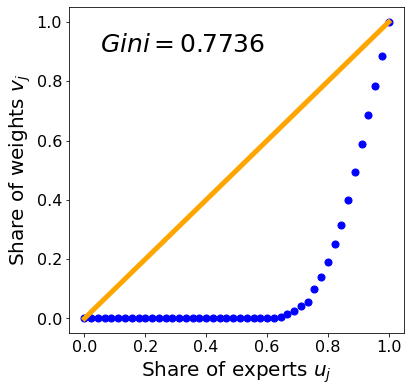

In [144]:
lorenz_curve(np.sort(weights_gen_mnistnetgate.cpu().numpy())) 

In [194]:
comb = combinations([i for i in range(10)], 2)
weights_mnistnet_gen_gate_dict = {c: weights_gen_mnistnetgate[i] for i, c in enumerate(comb)}

In [202]:
sum = 0.0
for key, value in sorted(weights_mnistnet_gen_gate_dict.items(), key=lambda item: item[1], reverse=True)[:10]:
    print("%s: %s" % (key, np.round(value.item(), 2)))
    sum += np.round(value.item(), 2)
print(sum)

(1, 7): 1132.52
(4, 9): 1014.73
(7, 9): 997.7
(3, 8): 969.9
(1, 6): 954.33
(1, 5): 934.19
(0, 1): 842.95
(2, 4): 632.29
(2, 6): 601.59
(3, 7): 525.16
8605.359999999999


In [245]:
weight_assignments_mnistnet_gen = correct_assignments(gen_mnistnetgates[1])
np.sum(weight_assignments_mnistnet_gen)/10000

0.7900427855812399

## Analyze expert accuracy

In [ ]:
expert_results = np.zeros((10, 10))

for gate in fmgates:
    experts = gate.experts
    for i in range(len(experts)):
        acc = experts[i].evaluate(test_sets[i], batch_size=128)['acc']
        label1 = experts[i].classes[0]
        label2 = experts[i].classes[1]
        expert_results[label1, label2] += acc
        expert_results[label2, label1] += acc

expert_results = expert_results / 3.0 

In [ ]:
sns.set(font_scale=1.8)
mask = np.zeros_like(expert_results)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20, 20))
    ax = sns.heatmap(np.round(expert_results, 4), annot=True, vmin=0.99, cbar=True, square=True, mask=mask, fmt='g', cmap="YlGnBu")
 